In [2]:
import pandas as pd
import librosa as mimosa
import audioread
import os
import matplotlib as plt
import seaborn as sns
import numpy as np

musicGender = os.listdir("musics") # returns list
genderlabel = []
musicData = []

for gender in musicGender:
    genderMusics = os.listdir('./musics/{}'.format(gender))
    for music in genderMusics:
        genderlabel.append(gender)
        
        amplitude, sr = mimosa.load('./musics/{}'.format(gender)+'/{}'.format(music))

        melSpec = mimosa.feature.melspectrogram(y = amplitude, sr=sr, n_mels=128, fmax=8000)    
        melSpec_to_db = mimosa.power_to_db(melSpec, ref=np.max)
        resized_melSpec = np.resize(melSpec_to_db, (melSpec_to_db.shape[0], 1293))
        
        musicData.append(resized_melSpec)

mfcc_specData=np.stack(musicData)
musicData=np.array(musicData)
genderlabel=np.array(genderlabel)


In [3]:
# tempo = []

# for i, data in enumerate(musicData):
#     t, beat = mimosa.beat.beat_track(y=musicData[i])
#     print('{}'.format(t)+ " {}".format(i))
#     tempo.append(t)


In [4]:
# d = {'tempo': tempo, 'genderlabel':genderlabel}
# tempoDF = pd.DataFrame(data=d)

# for t in tempoDF:
#     print(tempoDF.index)

In [5]:
# sns.barplot(data=tempoDF, x="genderlabel"  ,y="tempo")

In [6]:
import sklearn.preprocessing as preProSkL

labelEncoder = preProSkL.LabelEncoder()
labelEncoded = labelEncoder.fit(genderlabel)
labelEncodedTrans = labelEncoded.transform(genderlabel)
# inverse_transform to revert to normal

In [7]:
# mfcc_specData = []

# for i, data in enumerate(musicData):
#     melSpec = mimosa.feature.melspectrogram(y = data)    
#     melSpec_to_db = mimosa.power_to_db(melSpec, ref=np.max)
#     mfcc_specData.append(melSpec_to_db)

# mfcc_specData=np.array(mfcc_specData)
# print(mfcc_specData)

In [8]:
# normalizar dados

from sklearn.preprocessing import StandardScaler

# sc_X=StandardScaler()
# mfcc_specData = sc_X.fit_transform(mfcc_specData)

# mfcc_specData.head()

mean = np.mean(musicData, axis=-1, keepdims=True)
std = np.std(musicData, axis=-1, keepdims=True)

# Normalize the array by subtracting the mean and dividing by the standard deviation
normalized_data = (musicData - mean) / std

print(len(normalized_data))


200


In [9]:
# # Normalização Min Max

# print(labelEncodedTrans[0:100])
# print(mfcc_specData[99])
# print(mfcc_specData[100])
# print(mfcc_specData[101])

# indexMin=0
# indexMax = 99

# for genre in labelEncodedTrans[indexMin:indexMax]

# # xScaled = (xAtual - xMin) / (xMax - xMin)

In [18]:
from sklearn.model_selection import KFold
from tensorflow import keras
import matplotlib.pyplot as pyplot

acc_per_fold = []
loss_per_fold = []

input_shape=(normalized_data.shape[1],normalized_data.shape[2],1)
fold_no = 1

kf = KFold(n_splits=2, random_state=42, shuffle=True)
for train, test in kf.split(normalized_data):
    model=keras.Sequential()
    #1st layer
    model.add(keras.layers.Conv2D(8,(3,3),activation="relu",input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3,3),strides=(2,2),padding="same")) 
    model.add(keras.layers.BatchNormalization())

    # #2nd layer
    # model.add(keras.layers.Conv2D(16,(3,3),activation="relu"))
    # model.add(keras.layers.MaxPool2D((3,3),strides=(2,2),padding="same")) #pooling
    # model.add(keras.layers.BatchNormalization())

    #3rd layer
    model.add(keras.layers.Conv2D(8,(1,1),activation="relu"))
    model.add(keras.layers.MaxPool2D((1,1),strides=(1,1),padding="same")) #pooling
    model.add(keras.layers.BatchNormalization())


    #flatten the output
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(4,activation="relu"))
    model.add(keras.layers.Dropout(0.4))

    #output layer
    model.add(keras.layers.Dense(2,activation="softmax"))

    optimizer=keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=['accuracy'])
    
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
        
    # normalized_data[train] = normalized_data[train].reshape((-1, normalized_data[train].shape[1], normalized_data[train].shape[2], 1))
    history = model.fit(normalized_data[train],labelEncodedTrans[train],epochs=25, validation_data=(normalized_data[test], labelEncodedTrans[test]))

    testError, testAccuracy = model.evaluate(normalized_data[test], labelEncodedTrans[test])
    print("Accuracy on test set is:{}".format(testAccuracy))

    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {testError}; {model.metrics_names[1]} of {testAccuracy*100}%')
    acc_per_fold.append(testAccuracy * 100)
    loss_per_fold.append(testError)

    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print('------------------------------------------------------------------------')
    
    # print("%s %s" % (train, test))
    # print( len(normalized_data[train]))
    # print( len(normalized_data[test]))

# print(normalized_data[train])
# X_train, X_test, y_train, y_test = normalized_data[train], normalized_data[test], labelEncodedTrans[train], labelEncodedTrans[test]

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/25
4/4 [==============================] - 3s 583ms/step - loss: 0.7227 - accuracy: 0.5700 - val_loss: 0.8146 - val_accuracy: 0.5100
Epoch 2/25
4/4 [==============================] - 2s 545ms/step - loss: 0.6348 - accuracy: 0.6900 - val_loss: 0.6190 - val_accuracy: 0.6500
Epoch 3/25
4/4 [==============================] - 2s 539ms/step - loss: 0.4059 - accuracy: 0.8900 - val_loss: 0.6625 - val_accuracy: 0.6000
Epoch 4/25
4/4 [==============================] - 2s 551ms/step - loss: 0.4787 - accuracy: 0.8600 - val_loss: 0.6474 - val_accuracy: 0.6200
Epoch 5/25
4/4 [==============================] - 2s 548ms/step - loss: 0.3402 - accuracy: 0.9500 - val_loss: 0.6738 - val_accuracy: 0.6100
Epoch 6/25
4/4 [==============================] - 2s 555ms/step - loss: 0.3833 - accuracy: 0.9000 - val_loss: 0.5801 - val_accuracy: 0.6700
Epoch 7/25
4/4 [==============================] - 2s 551ms/step

In [ ]:
# import sklearn.model_selection as modelSelec

# X_train, X_test, y_train, y_test = modelSelec.train_test_split(normalized_data, labelEncodedTrans, test_size=0.25, random_state=42)

# # X_train, X_test, y_val, y_val = modelSelec.train_test_split(mfcc_specData, labelEncodedTrans, test_size=0.5, random_state=42)
# X_test,X_validation,y_test,y_validation=modelSelec.train_test_split(X_test,y_test,test_size=0.2, random_state=42)


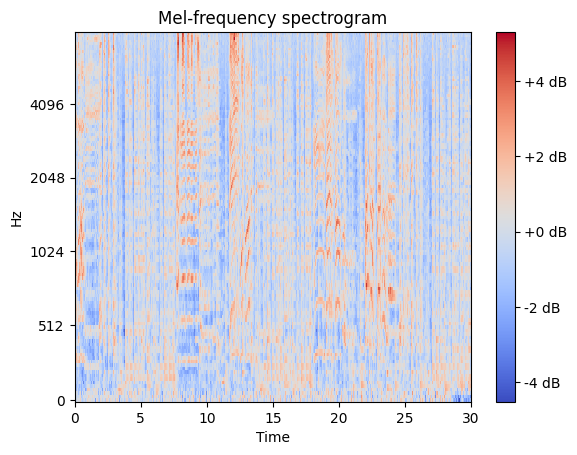

In [ ]:
import matplotlib.pyplot as pyplot



fig, ax = pyplot.subplots()
img = mimosa.display.specshow(normalized_data[12], x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')

ax.set(title='Mel-frequency spectrogram')

pyplot.savefig('0.png')

  

In [ ]:
# import matplotlib.pyplot as pyplot

# musicCounter = 0

# path = './musicsPlts'
# if not os.path.exists(path):
#     os.mkdir(path)

# for gender in musicGender:
#     genderPath = '{}'.format(path) + '/{}'.format(gender)
#     if not os.path.exists(genderPath):
#         os.mkdir(genderPath)

# for index in range(len(mfcc_specData)):
#     fig, ax = pyplot.subplots()
#     img = mimosa.display.specshow(mfcc_specData[index], x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax)
#     fig.colorbar(img, ax=ax, format='%+2.0f dB')

#     ax.set(title='Mel-frequency spectrogram')

#     if index % 100 == 0:
#         musicCounter = 0
    
#     pyplot.savefig('{}'.format(path) + '/{}'.format(genderlabel[index]) + '/{}'.format(musicCounter) + '.png')

#     musicCounter +=1




In [ ]:
print(X_train.shape)
input_shape=(X_train.shape[1],X_train.shape[2],1)
print(X_train.shape)
print(input_shape)


NameError: name 'X_train' is not defined

In [ ]:
from tensorflow import keras

model=keras.Sequential()
#1st layer
model.add(keras.layers.Conv2D(24,(3,3),activation="relu",input_shape=input_shape))
model.add(keras.layers.MaxPool2D((3,3),strides=(2,2),padding="same")) 
model.add(keras.layers.BatchNormalization())

#2nd layer
model.add(keras.layers.Conv2D(24,(3,3),activation="relu"))
model.add(keras.layers.MaxPool2D((3,3),strides=(2,2),padding="same")) #pooling
model.add(keras.layers.BatchNormalization())

#3rd layer
model.add(keras.layers.Conv2D(24,(2,2),activation="relu"))
model.add(keras.layers.MaxPool2D((2,2),strides=(2,2),padding="same")) #pooling
model.add(keras.layers.BatchNormalization())


#flatten the output
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(20,activation="relu"))
model.add(keras.layers.Dropout(0.2))

#output layer
model.add(keras.layers.Dense(10,activation="softmax"))

optimizer=keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy'])


In [ ]:
print(X_train.shape[0])
print(X_train.shape[0])
print(X_train.reshape((-1, X_train.shape[1], X_train.shape[2], 1)))

In [ ]:
X_train = X_train.reshape((-1, X_train.shape[1], X_train.shape[2], 1))
print(X_train.shape[0])
# history = model.fit(X_train,y_train,epochs=35, validation_data=(X_validation, y_validation))
history = model.fit(X_train,y_train,epochs=35, validation_data=(X_test, y_test))

In [ ]:
import matplotlib.pyplot as pyplot

print(history.history)

testError, testAccuracy = model.evaluate(X_test, y_test)
print("Accuracy on test set is:{}".format(testAccuracy))

pyplot.plot(history.history['accuracy'], label='train_accuracy')
pyplot.plot(history.history['val_accuracy'], label = 'val_accuracy')
pyplot.xlabel('Epoch')
pyplot.ylabel('Accuracy')
pyplot.ylim([0.1, 1.1])
pyplot.legend(loc='lower right')

In [ ]:
from sklearn.metrics import confusion_matrix

Y_previsto = model.predict(X_test)

cm = confusion_matrix(y_test,Y_previsto)

sns.heatmap(cm, annot=True, fmt="d")